In [1]:
from pyspark.sql import SparkSession

spark = (
    SparkSession
    .builder
    .master('local[*]')
    .appName('PySparkShell')
    .getOrCreate()
)

In [2]:
import sys
import os

sys.path.append('/dbfs/cdr/library')

from pandas import set_option
set_option('display.max.columns', None)

# TODO: remove for Databricks
from dbutils import DBUtils, FileInfo
dbutils = DBUtils()

In [3]:
from sparkFunctions import create_tmp_parquet

from typing import Dict, List, Optional

# adds file system prefix /dbfs for local and dbfs: for databricks
def resolve(path: str) -> Optional[str]:
    try:
        prefix = dbutils.fs.ls('/')[0].path[:5]
        return prefix + path
    except Exception as error:
        print(error)

In [5]:
from pyspark.sql import Column, DataFrame
from pyspark.sql.functions import approx_count_distinct, col, collect_set, date_trunc, desc, size, trim

from pyspark.storagelevel import StorageLevel

from typing import Dict, List

def truncateTimestamp(dataFrame: DataFrame) -> DataFrame:
    for column, dtype in dataFrame.dtypes:
        if dtype == 'timestamp':
            dataFrame = dataFrame.withColumn(column, date_trunc('second', column))

    return dataFrame


def trimString(dataFrame: DataFrame) -> DataFrame:
    for column, dtype in dataFrame.dtypes:
        if dtype == 'string':
            dataFrame = dataFrame.withColumn(column, trim(column))
        
    return dataFrame

In [6]:
# change for Databricks
FOLDER = '/automation'

ZOOM_FOLDER = os.path.join(FOLDER, 'ZoomData')
BASE_FOLDER = os.path.join(FOLDER, 'OnBase')

In [7]:
%%time

path = os.path.join(BASE_FOLDER, 'rm_DVStatementRequestActivityRecords.parquet')
activities = spark.read.parquet(resolve(path))

dates = [
    'ActivityDate',
    'FollowUpDate'
]

for column in dates:
    activities = activities.withColumn(column, col(column).cast('date'))
    
activities = truncateTimestamp(activities)
activities = trimString(activities)
    
activities = create_tmp_parquet(spark, activities, '/tmp/ACTIVITIES')
    
activities.limit(5).toPandas()

CPU times: user 114 ms, sys: 42.8 ms, total: 157 ms
Wall time: 24.9 s


,ObjectID,CreatedDate,ReferenceNumber,CustomerVendorName,JobNumber,JobName,ContactType,ActivityUser,ActivityDate,FollowUpDate,STNID,Notes,Outcome,ActivityType,CustVendorObjectID,VendorContactObjectID,StatementRequestObjectID,CreatedBy
0,28785475,2020-11-02 06:41:33,1279250,ULINE,3412,Carolinas Shared Service - 3412,Call,ASIBLEY,2020-11-01,2020-11-03,NaN,This is a test - Updated,None,None,21259327,NaN,25422522,ASIBLEY
1,28785637,2020-11-02 06:47:27,1279250,ULINE,3412,Carolinas Shared Service - 3412,Email,ASIBLEY,2020-11-01,2020-11-04,NaN,Test 2 - Updated,None,None,21259327,NaN,25422522,ASIBLEY
2,28786094,2020-11-02 06:52:58,1279250,ULINE,3412,Carolinas Shared Service - 3412,Client Email,ASIBLEY,2020-11-01,2020-11-03,NaN,Test 3,None,None,21259327,NaN,25422522,ASIBLEY
3,28838136,2020-11-04 12:47:58,1287154,BIOCOMPOSITES INC.,3435,The Christ Hospital - 3435,None,bwilliams1,2020-11-03,None,6192802.0,Statement Request creation skipped because thi...,None,None,27542411,NaN,27781594,ASIBLEY
4,28838138,2020-11-04 12:48:02,1225130,BONA FIDE COMMERCIAL SERVICES,3177,UC Health - 3177,None,jdagher,2020-11-03,None,6192806.0,Statement Request creation skipped because thi...,None,None,24317597,NaN,25860124,ASIBLEY


In [8]:
%%time
path = os.path.join(BASE_FOLDER, 'rm_DVStatementRequests.parquet')
requests = spark.read.parquet(resolve(path))

dates = [
    'RequestDate',
    'LastActivityDate'
]

for column in dates:
    requests = requests.withColumn(column, col(column).cast('date'))

requests = requests.withColumn('Volume', col('Volume').cast('double'))

requests = truncateTimestamp(requests)    
requests = trimString(requests)

requests = create_tmp_parquet(spark, requests, '/tmp/REQUESTS')

requests.limit(5).toPandas()

CPU times: user 118 ms, sys: 13.4 ms, total: 131 ms
Wall time: 14.4 s


,JobNo,JobTier,CustomerName,CustVendorID,VendorNo,CustVendorGroupID,WNC,StatementWNC,VendorGroupName,Volume,RequestDate,ReferenceNumber,Status,RequestMethod,RequestType,Contact,RequesterFullName,RequestText,LastActivityDate,LastStatementReceivedDate,CreatedDate,CallsheetNo,ObjectID,CallerStatus,ReconStatus,CurrentAssigneeID,CurrentAssigneeName,EnteredReconDate,LastReconQueueName,LastReconQueueEntryDate,AccountsReceived,AccountsRequested,MessageID,VendorContactObjectID,WebsiteVendor,WNCSpecialHandling,NeedLeadVendor
0,3427,NaN,New Hanover Regional Medical Center,415960,16845,415959,NaN,NaN,A M COFFEE DISTRIBUTORS LLC,0.0,2021-09-02,1285660,No Receipt,MassEmail,Caller,amcoffeedist@gmail.com,Cindy Allen,None,2021-08-22,NaT,2021-09-02 22:50:28,C-338914,36846273,Sent Authorization Letter,None,19272454,Yodit Kahssai,NaT,None,NaT,NaN,NaN,hONrG5xpTUyiQB4Rs7gb0g,29510277.0,NaN,NaN,NaN
1,3427,NaN,New Hanover Regional Medical Center,415960,16845,415959,NaN,NaN,A M COFFEE DISTRIBUTORS LLC,0.0,2020-07-23,1285660,Superceded,MassEmail,None,amcoffeedist@gmail.com,Jessica Rinehart,None,2020-07-23,NaT,2020-07-24 12:29:52,C-338914,26681846,None,None,19272454,Yodit Kahssai,NaT,None,NaT,NaN,NaN,None,NaN,NaN,NaN,NaN
2,3427,NaN,New Hanover Regional Medical Center,415960,16845,415959,NaN,NaN,A M COFFEE DISTRIBUTORS LLC,0.0,2020-07-30,1285660,Superceded,MassEmail,Mass 1,amcoffeedist@gmail.com,Jessica Rinehart,None,2020-07-30,NaT,2020-07-31 04:05:15,C-338914,26819776,None,None,19272454,Yodit Kahssai,NaT,None,NaT,NaN,NaN,None,NaN,NaN,NaN,NaN
3,3427,NaN,New Hanover Regional Medical Center,415960,16845,415959,NaN,NaN,A M COFFEE DISTRIBUTORS LLC,0.0,2021-01-18,1285660,Superceded,MassEmail,Caller,amcoffeedist@gmail.com,Jessica Rinehart,None,2020-07-30,NaT,2021-01-19 07:01:21,C-338914,30690711,Sent Authorization Letter,None,8398263,Rebekah Dykema,NaT,None,NaT,NaN,NaN,None,29510277.0,NaN,NaN,NaN
4,3427,NaN,New Hanover Regional Medical Center,415960,16845,415959,NaN,NaN,A M COFFEE DISTRIBUTORS LLC,0.0,2021-08-18,1285660,Superceded,MassEmail,Mass 1,amcoffeedist@gmail.com,Cindy Allen,None,2021-08-22,NaT,2021-08-22 20:03:52,C-338914,36365526,Sent Authorization Letter,None,8398263,Rebekah Dykema,NaT,None,NaT,NaN,NaN,hONrG5xpTUyiQB4Rs7gb0g,29510277.0,NaN,NaN,NaN


In [9]:
requests.createOrReplaceTempView(name='requests')
activities.createOrReplaceTempView(name='activities')

In [10]:
%%time
query = """
SELECT
    activities.ContactType,
    activities.ActivityUser,
    activities.Outcome,
    activities.ActivityType,
    requests.CallerStatus,
    requests.CustomerName,
    requests.RequestType,
    requests.RequesterFullName,
    requests.CurrentAssigneeName,
    requests.RequestMethod,
    requests.Status
FROM
    requests
        INNER JOIN
            activities ON
                requests.ObjectID = activities.StatementRequestObjectID
"""


table = spark.sql(query).na.fill(value='N/A')

table = create_tmp_parquet(spark, table, '/tmp/REQUEST-ACTIVITY')

CPU times: user 5.55 ms, sys: 2.85 ms, total: 8.4 ms
Wall time: 12.7 s


In [11]:
import h2o
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: java version "1.8.0_271"; Java(TM) SE Runtime Environment (build 1.8.0_271-b09); Java HotSpot(TM) 64-Bit Server VM (build 25.271-b09, mixed mode)
  Starting server from /Users/curtispassorelli/Sandbox/Python37/databricks/lib/python3.7/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/88/v0bhg9n94y193z5q51d06qq40000gn/T/tmphgjjo118
  JVM stdout: /var/folders/88/v0bhg9n94y193z5q51d06qq40000gn/T/tmphgjjo118/h2o_curtispassorelli_started_from_python.out
  JVM stderr: /var/folders/88/v0bhg9n94y193z5q51d06qq40000gn/T/tmphgjjo118/h2o_curtispassorelli_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,04 secs
H2O_cluster_timezone:,America/Detroit
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.34.0.1
H2O_cluster_version_age:,"28 days, 20 hours and 37 minutes"
H2O_cluster_name:,H2O_from_python_curtispassorelli_roixo6
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.542 Gb
H2O_cluster_total_cores:,4
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


In [12]:
# TODO: change to dbfs:/
path = '/tmp/REQUEST-ACTIVITY'

table = h2o.import_file(path, destination_frame='REQUEST-ACTIVITY')
table.head()

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


ContactType,ActivityUser,Outcome,ActivityType,CallerStatus,CustomerName,RequestType,RequesterFullName,CurrentAssigneeName,RequestMethod,Status
N/A,knorman,N/A,N/A,N/A,University Hospitals Health System,Macro,Marco Polo,Kermitha Norman,Macro,Superceded
Call,cmarklevitz,N/A,N/A,N/A,University Hospitals Health System,Macro,Marco Polo,Kermitha Norman,Macro,Superceded
N/A,Bill Wilhoit,N/A,Note Only,N/A,Hartford,N/A,Tim Kornoelje,Becky Williams,WNC,Superceded
Call,jdagher,N/A,N/A,N/A,Boston Childrens Hospital,N/A,Bill Wilhoit,Josephine Dagher,MassEmail,Fully Received
Call,jdagher,N/A,N/A,N/A,Boston Childrens Hospital,N/A,Bill Wilhoit,Josephine Dagher,MassEmail,Fully Received
Call,jdagher,N/A,N/A,N/A,Boston Childrens Hospital,N/A,Bill Wilhoit,Josephine Dagher,MassEmail,Fully Received
Call,croark,N/A,N/A,N/A,Advocate Aurora Health,N/A,Jessica Rinehart,Carla Roark,MassEmail,Superceded
N/A,croark,N/A,N/A,N/A,Advocate Aurora Health,N/A,Jessica Rinehart,Carla Roark,MassEmail,Superceded
Call,jdagher,N/A,N/A,N/A,Boston Childrens Hospital,Mass 1,Bill Wilhoit,Josephine Dagher,MassEmail,Superceded
Call,jdagher,N/A,N/A,N/A,Boston Childrens Hospital,Mass 1,Bill Wilhoit,Josephine Dagher,MassEmail,Superceded


In [25]:
table.types

{'ContactType': 'enum',
 'ActivityUser': 'enum',
 'Outcome': 'enum',
 'ActivityType': 'enum',
 'CallerStatus': 'enum',
 'CustomerName': 'enum',
 'RequestType': 'enum',
 'RequesterFullName': 'enum',
 'CurrentAssigneeName': 'enum',
 'RequestMethod': 'enum',
 'Status': 'enum'}

In [21]:
x = [
    'ContactType',
    'ActivityUser',
    'Outcome',
    'ActivityType',
    'CallerStatus',
    'CustomerName',
    'RequestType',
    'RequesterFullName',
    'CurrentAssigneeName',
    'RequestMethod'
]

y = 'Status'

### Random Forest

In [26]:
%%time
from h2o.estimators import H2ORandomForestEstimator

model = H2ORandomForestEstimator()

model.train(x=x, y=y, training_frame=table)

drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
CPU times: user 2.4 s, sys: 347 ms, total: 2.74 s
Wall time: 2min 44s
Model Details
H2ORandomForestEstimator :  Distributed Random Forest
Model Key:  DRF_model_python_1634152354838_3


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,50.0,300.0,28392748.0,1.0,20.0,17.23,2.0,9370.0,4336.11




ModelMetricsMultinomial: drf
** Reported on train data. **

MSE: 0.0964069120735327
RMSE: 0.3104946248705969
LogLoss: 0.32867365671435667
Mean Per-Class Error: 0.3985270598904833
AUC: NaN
AUCPR: NaN
Multinomial auc values: Table is not computed because it is disabled (model parameter 'auc_type' is set to AUTO or NONE) or due to domain size (maximum is 50 domains).
Multinomial auc_pr values: Table is not computed because it is disabled (model parameter 'auc_type' is set to AUTO or NONE) or due to domain size (maximum is 50 domains).

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class


,Account Identification,Fully Received,N/A,No Receipt,Partial Receipt,Superceded,Error,Rate
0,21252.0,10118.0,0.0,164.0,240.0,827.0,0.348118,"11,349 / 32,601"
1,3950.0,167663.0,0.0,721.0,740.0,12787.0,0.097912,"18,198 / 185,861"
2,0.0,0.0,0.0,0.0,0.0,1.0,1.000000,1 / 1
3,93.0,411.0,0.0,71788.0,26.0,8413.0,0.110775,"8,943 / 80,731"
4,1417.0,7720.0,0.0,159.0,3138.0,473.0,0.756876,"9,769 / 12,907"
5,347.0,20567.0,1.0,2351.0,143.0,278717.0,0.077481,"23,409 / 302,126"
6,27059.0,206479.0,1.0,75183.0,4287.0,301218.0,0.116682,"71,669 / 614,227"



Top-6 Hit Ratios: 


,k,hit_ratio
0,1,0.883318
1,2,0.979174
2,3,0.995251
3,4,0.999505
4,5,0.999822
5,6,1.000000



Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_classification_error,training_auc,training_pr_auc
0,,2021-10-13 15:26:43,0.020 sec,0.0,NaN,NaN,NaN,NaN,NaN
1,,2021-10-13 15:26:45,2.864 sec,1.0,0.327774,0.879411,0.125608,NaN,NaN
2,,2021-10-13 15:26:50,7.836 sec,3.0,0.323095,0.760912,0.123746,NaN,NaN
3,,2021-10-13 15:26:56,13.478 sec,5.0,0.319810,0.644608,0.121645,NaN,NaN
4,,2021-10-13 15:27:02,19.675 sec,7.0,0.316818,0.549851,0.120142,NaN,NaN
5,,2021-10-13 15:27:08,25.411 sec,9.0,0.314840,0.482023,0.119069,NaN,NaN
6,,2021-10-13 15:27:13,30.822 sec,11.0,0.313687,0.440582,0.118527,NaN,NaN
7,,2021-10-13 15:27:21,38.033 sec,13.0,0.313255,0.412479,0.118195,NaN,NaN
8,,2021-10-13 15:27:27,44.836 sec,15.0,0.312926,0.393215,0.117976,NaN,NaN
9,,2021-10-13 15:27:35,51.939 sec,17.0,0.312463,0.378582,0.117642,NaN,NaN



See the whole table with table.as_data_frame()

Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,CallerStatus,6.173066e+06,1.000000,0.566565
1,ActivityUser,1.119488e+06,0.181350,0.102747
2,CustomerName,1.052096e+06,0.170433,0.096562
3,CurrentAssigneeName,7.167087e+05,0.116103,0.065780
4,RequesterFullName,6.329844e+05,0.102540,0.058095
5,Outcome,5.222274e+05,0.084598,0.047930
6,RequestMethod,2.927305e+05,0.047421,0.026867
7,RequestType,2.489995e+05,0.040336,0.022853
8,ContactType,8.518530e+04,0.013800,0.007818
9,ActivityType,5.210981e+04,0.008441,0.004783


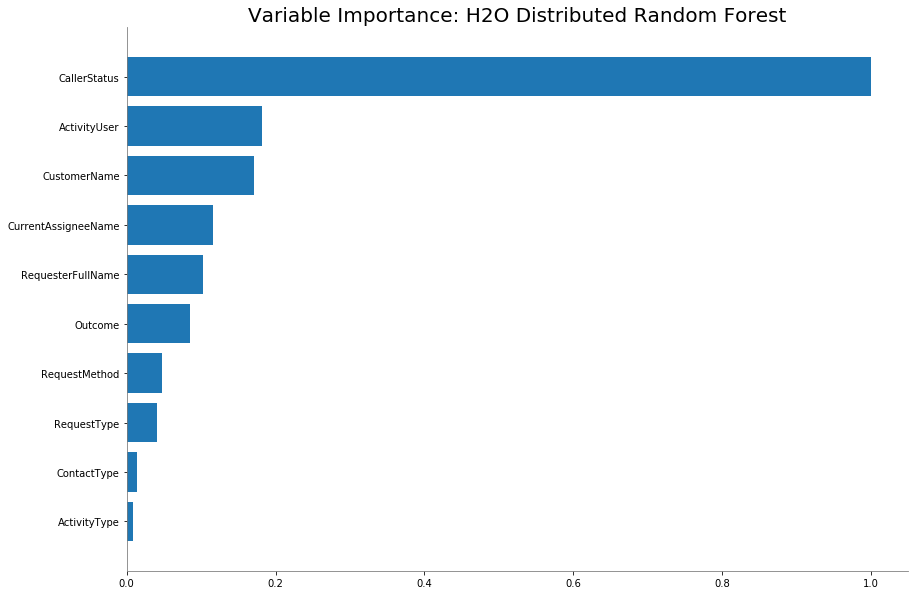

In [27]:
model.varimp_plot()

In [28]:
importance = model.varimp(use_pandas=True)
importance

,variable,relative_importance,scaled_importance,percentage
0,CallerStatus,6.173066e+06,1.000000,0.566565
1,ActivityUser,1.119488e+06,0.181350,0.102747
2,CustomerName,1.052096e+06,0.170433,0.096562
3,CurrentAssigneeName,7.167087e+05,0.116103,0.065780
4,RequesterFullName,6.329844e+05,0.102540,0.058095
5,Outcome,5.222274e+05,0.084598,0.047930
6,RequestMethod,2.927305e+05,0.047421,0.026867
7,RequestType,2.489995e+05,0.040336,0.022853
8,ContactType,8.518530e+04,0.013800,0.007818
9,ActivityType,5.210981e+04,0.008441,0.004783


### Extreme-Gradient Boosting

In [29]:
from h2o.estimators import H2OXGBoostEstimator

xgb_model = H2OXGBoostEstimator()

xgb_model.train(x=x, y=y, training_frame=table)

xgboost Model Build progress: |██████████████████████████████████████████████████| (done) 100%
Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_model_python_1634152354838_4


Model Summary: 


,,number_of_trees
0,,50.0




ModelMetricsMultinomial: xgboost
** Reported on train data. **

MSE: 0.12248309168830719
RMSE: 0.34997584443545127
LogLoss: 0.411032173933334
Mean Per-Class Error: 0.4482708593148705
AUC: NaN
AUCPR: NaN
Multinomial auc values: Table is not computed because it is disabled (model parameter 'auc_type' is set to AUTO or NONE) or due to domain size (maximum is 50 domains).
Multinomial auc_pr values: Table is not computed because it is disabled (model parameter 'auc_type' is set to AUTO or NONE) or due to domain size (maximum is 50 domains).

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class


,Account Identification,Fully Received,N/A,No Receipt,Partial Receipt,Superceded,Error,Rate
0,17692.0,13559.0,0.0,211.0,192.0,947.0,0.457317,"14,909 / 32,601"
1,3390.0,163432.0,0.0,1127.0,358.0,17554.0,0.120676,"22,429 / 185,861"
2,0.0,0.0,0.0,0.0,0.0,1.0,1.000000,1 / 1
3,46.0,428.0,0.0,66694.0,5.0,13558.0,0.173874,"14,037 / 80,731"
4,1154.0,9154.0,0.0,228.0,1836.0,535.0,0.857752,"11,071 / 12,907"
5,307.0,20595.0,0.0,3221.0,49.0,277954.0,0.080006,"24,172 / 302,126"
6,22589.0,207168.0,0.0,71481.0,2440.0,310549.0,0.141021,"86,619 / 614,227"



Top-6 Hit Ratios: 


,k,hit_ratio
0,1,0.858979
1,2,0.970602
2,3,0.992487
3,4,0.999422
4,5,1.000000
5,6,1.000000



Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_classification_error,training_auc,training_pr_auc
0,,2021-10-13 15:31:52,0.020 sec,0.0,0.833333,1.791759,0.508120,NaN,NaN
1,,2021-10-13 15:31:56,3.830 sec,1.0,0.715456,1.282371,0.187159,NaN,NaN
2,,2021-10-13 15:32:00,8.285 sec,2.0,0.633469,1.045515,0.184253,NaN,NaN
3,,2021-10-13 15:32:06,13.991 sec,3.0,0.571784,0.898895,0.182174,NaN,NaN
4,,2021-10-13 15:32:14,21.816 sec,5.0,0.491554,0.726383,0.181246,NaN,NaN
5,,2021-10-13 15:32:22,30.249 sec,7.0,0.446168,0.630550,0.177752,NaN,NaN
6,,2021-10-13 15:32:32,39.839 sec,9.0,0.418991,0.571170,0.168806,NaN,NaN
7,,2021-10-13 15:32:44,52.355 sec,12.0,0.398443,0.523199,0.166001,NaN,NaN
8,,2021-10-13 15:32:54,1 min 1.721 sec,14.0,0.390141,0.503892,0.163111,NaN,NaN
9,,2021-10-13 15:33:04,1 min 11.707 sec,16.0,0.384099,0.489049,0.160856,NaN,NaN



Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,CallerStatus.Statement Received,899380.812500,1.000000,0.463006
1,CallerStatus.Remove From Scope,201255.796875,0.223772,0.103607
2,RequestType.Caller,77099.062500,0.085725,0.039691
3,CallerStatus.N/A,57909.867188,0.064389,0.029812
4,RequesterFullName.Cindy Allen,43135.957031,0.047962,0.022207
5,CallerStatus.Sent Authorization Letter,39050.566406,0.043419,0.020103
6,CurrentAssigneeName.Mark Beuschel,30725.445312,0.034163,0.015818
7,CallerStatus.Needs Research,28558.970703,0.031754,0.014702
8,CallerStatus.Left Voicemail,27036.681641,0.030061,0.013919
9,RequesterFullName.OnBase Processing Service,26041.437500,0.028955,0.013406



See the whole table with table.as_data_frame()


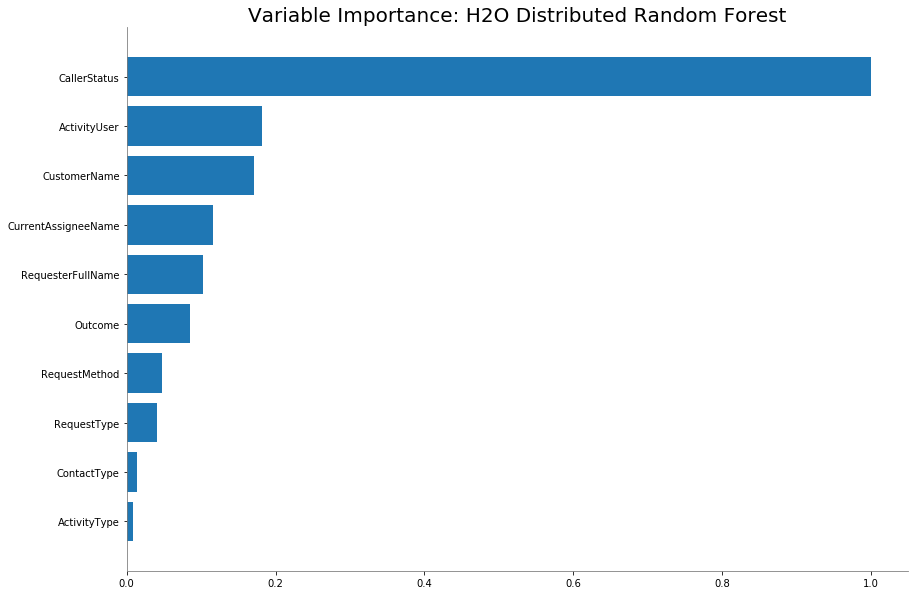

In [31]:
model.varimp_plot()

In [ ]:
spark.stop()